## Library

In [1]:
!pip install gpytorch
!pip install wandb

In [2]:
import optuna
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
from pytorch_metric_learning import losses
from torch.cpu.amp import GradScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

from models.mil_resnet import CNN_ATT_GP, CNN_GP_ATT, SupConResnet, LinearClassifier, DKLModel
from utils import hard_negative_mining as hnm
import gpytorch
from layers.gaussian_process import SingletaskGPModel, PGLikelihood

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

/home/hskha23/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Configurations

### GPU Configuration

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

### Seed Everything

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

### Constant Info

In [7]:
import yaml
with open("../config.yaml") as file:
    config = yaml.safe_load(file)

# Accessing constants from config
HEIGHT = config['height']
WIDTH = config['width']
CHANNELS = config['channels']

TRAIN_BATCH_SIZE = config['train_batch_size']
VALID_BATCH_SIZE = config['valid_batch_size']
TEST_BATCH_SIZE = config['test_batch_size']
TEST_SIZE = config['test_size']
VALID_SIZE = config['valid_size']

TRAINING_TYPE = config['training_type']
GP_MODEL = config['gp_model']

MAX_SLICES = config['max_slices']
SHAPE = tuple(config['shape'])

NUM_EPOCHS = config['num_epochs']
LEARNING_RATE = config['learning_rate']
INDUCING_POINTS = config['inducing_points']
THRESHOLD = config['threshold']

NUM_CLASSES = config['num_classes']

TARGET_LABELS = config['target_labels']

MODEL_PATH = config['model_path']
DEVICE = config['device']

PROJECTION_LOCATION = config['projection_location']
PROJECTION_HIDDEN_DIM = config['projection_hidden_dim']
PROJECTION_OUTPUT_DIM = config['projection_output_dim']

ATTENTION_HIDDEN_DIM = config['attention_hidden_dim']

In [8]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")
ROOT_DIR = '/kaggle/input/rsna-mil-training/' if KAGGLE else None
DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-ich-mil/'
DICOM_DIR = DATA_DIR
CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_dataset_1150.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR

# Load patient scan labels
# patient_scan_labels = pd.read_csv(CSV_PATH)
patient_scan_labels = pd.read_csv(CSV_PATH, nrows=1150)

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

Running locally


In [9]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("Wandb key")
# 
# wandb.login(key=key, relogin=True)

In [10]:
patient_scan_labels.head()

,filename,labels,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,patient_label
0,"['ID_e29b63250.dcm', 'ID_766be7451.dcm', 'ID_b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_005f241d,ID_07e2cf7b4b,"['[-125.000, -131.252, 63.879]', '[-125.000, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['30', '30', '30', '30', '30', '30', '30', '30...","['80', '80', '80', '80', '80', '80', '80', '80...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
1,"['ID_b2e23d464.dcm', 'ID_0d5c28287.dcm', 'ID_3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0075b28c,ID_0373dbdd02,"['[-125.000000, -130.318451, 38.952644]', '[-1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['30', '30', '30', '30', '30', '30', '30', '30...","['80', '80', '80', '80', '80', '80', '80', '80...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
2,"['ID_080e55858.dcm', 'ID_ad9ea42be.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",ID_00760731,ID_006a2c59e4,"['[-125.000, -146.200, 5.250]', '[-125.000, -1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['40', '40', '40', '40', '40', '40', '40', '40...","['150', '150', '150', '150', '150', '150', '15...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1
3,"['ID_6407b752d.dcm', 'ID_bff0001cf.dcm', 'ID_1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00859e11,ID_01f49be39f,"['[-125.000, -121.018, -1.452]', '[-125.000, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['40', '40', '40', '40', '40', '40', '40', '40...","['150', '150', '150', '150', '150', '150', '15...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1
4,"['ID_db255faea.dcm', 'ID_68ba9321f.dcm', 'ID_d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Data Preprocessing

### Splitting the Dataset

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']
    if test_size > 0:
        # First, split off the test set
        train_val_labels, test_labels = train_test_split(
            patient_scan_labels,
            test_size=test_size,
            stratify=labels,
            random_state=random_state
        )

        # Calculate the validation size relative to the train_val set
        val_size_adjusted = val_size / (1 - test_size)

        # Split the train_val set into train and validation sets
        train_labels, val_labels = train_test_split(
            train_val_labels,
            test_size=val_size_adjusted,
            stratify=train_val_labels['patient_label'],
            random_state=random_state
        )
    else:
        train_labels, val_labels = train_test_split(
            patient_scan_labels,
            test_size=val_size,
            stratify=labels,
            random_state=random_state
        )
        test_labels = None

    return train_labels, val_labels, test_labels

### Augmentation

In [12]:
class DatasetAugmentor:
    def __init__(self, height, width, levels=2, seed=None):
        self.height = height
        self.width = width
        self.levels = levels  # Dynamic number of levels
        self.seed = seed
        self.params = []

        # Create different levels of transforms based on the number of levels specified
        for i in range(levels):
            factor = (i + 1) / levels
            self.params.append(
                self._create_transform(
                    degrees=int(15 * factor), 
                    translate_range=(0.2 * factor, 0.2 * factor),
                    scale_range=(1 - 0.2 * factor, 1 + 0.2 * factor),
                    brightness_range=0.2 * factor,
                    contrast_range=0.2 * factor,
                    blur_sigma_range=(0.5 * factor, 1.0 * factor),
                    apply_elastic=(i >= levels // 2),
                    level_name=f'level_{i + 1}'
                )
            )

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range, brightness_range, contrast_range, blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")
        sampled_values = {
            "degrees": abs(self._sample_value((-degrees, degrees))),
            "translate": (abs(self._sample_value(translate_range[0])), abs(self._sample_value(translate_range[1]))),
            "scale": self._sample_value(scale_range),
            "brightness": self._sample_value(brightness_range),
            "contrast": self._sample_value(contrast_range),
            "blur_sigma": self._sample_value(blur_sigma_range),
            "apply_elastic": apply_elastic
        }
        
        print(sampled_values)
        return sampled_values

    def apply_transform(self, image, level):
        params = self.params[level]
        transform = self._get_transform(params, channels=image.shape[0])
        return transform(image)

    def _get_transform(self, params, channels=3):
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            transforms.ToTensor(),
        ]

        if channels == 3:
            transform_list.extend([
                transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
                transforms.RandomApply([self._channel_shuffle], p=0.3)
            ])
        elif channels == 1:
            transform_list.append(transforms.Normalize(mean=[0.16774411], std=[0.3101935]))

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

In [13]:
augmentor = DatasetAugmentor(224, 224, seed=42)

Creating 'level_1' transform with parameters:
{'degrees': 1.9519751784103718, 'translate': (0.1, 0.1), 'scale': 1.027885359691577, 'brightness': 0.1, 'contrast': 0.1, 'blur_sigma': 0.4098566996144709, 'apply_elastic': False}
Creating 'level_2' transform with parameters:
{'degrees': 4.182803953736514, 'translate': (0.2, 0.2), 'scale': 1.0557707193831534, 'brightness': 0.2, 'contrast': 0.2, 'blur_sigma': 0.8197133992289418, 'apply_elastic': True}


### Dataset Generator

In [14]:
from dataset_generators.RSNA_Dataset import MedicalScanDataset

In [15]:
class TrainDatasetGenerator(MedicalScanDataset):
    """Dataset class for training medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

class TestDatasetGenerator(MedicalScanDataset):
    """Dataset class for testing medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [16]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)

In [17]:
len(original_dataset)

1000

In [18]:
x,y,z, _ = original_dataset[0]
print(x.shape, y.shape, z.shape)

torch.Size([57, 1, 224, 224]) torch.Size([57]) torch.Size([])


In [19]:
# # Check if the returned data is valid
# if x is not None:
#     # Convert the tensor to a numpy array
#     x_np = x.numpy()
#
#     # Check the number of dimensions and squeeze if necessary
#     if x_np.ndim == 4:  # RGB images
#         # Plot each slice
#         fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
#         for i, ax in enumerate(axes):
#             ax.imshow(x_np[i].transpose(1, 2, 0))  # Convert CHW to HWC
#             ax.axis('off')
#         plt.show()
#     elif x_np.ndim == 3:  # Grayscale images
#         # Plot each slice
#         fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
#         for i, ax in enumerate(axes):
#             ax.imshow(x_np[i], cmap='gray')
#             ax.axis('off')
#         plt.show()
#     else:
#         raise ValueError(f"Unexpected number of dimensions: {x_np.ndim}")
# else:
#     print("No data available for this patient.")


In [20]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    # original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

## NTXent Loss

In [21]:
class NTXentLoss(losses.NTXentLoss):
    def __init__(self, temperature, **kwargs):
        super().__init__(temperature=temperature, **kwargs)
        self.temperature = temperature

    def forward(self, embeddings, labels=None, hard_pairs=None):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)

        if labels == None:
            # Self-supervised labels
            batch_size = feature_vectors_normalized.size(0) // 2  # Assuming equal size for both embeddings
            labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)

        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )

        if labels == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        if hard_pairs == None:
            return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

## Augmentation For Contrastive Learning

In [22]:
# Version 2: Avg time taken: 0.05 seconds for 1 augmentation (w ResizedCrop)
def augment_batch(batch_images):
    if CHANNELS == 1:
        batch_size, num_instances, channels, height, width = batch_images.shape
    else:
        batch_size, num_instances, height, width, channels = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop((height, width), scale=(0.8, 1.1)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    ])

    # Apply transformations directly on the tensor without converting to PIL
    augmented_batch = torch.empty_like(batch_images)  # Preallocate memory for augmented images

    for i in range(batch_size):
        for j in range(num_instances):
            if CHANNELS == 1:
                augmented_batch[i, j] = aug_transform(batch_images[i, j])
            else:
                augmented_batch[i, j] = aug_transform(batch_images[i, j].permute(2, 0, 1)).permute(1, 2, 0)

    return augmented_batch.cuda()  # Move the augmented batch to GPU

## Training and Evaluation

### Metrics Calculation

#### Performance Metrics

In [23]:
def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='macro'),
        "recall": recall_score(labels, predictions, average='macro'),
        "f1": f1_score(labels, predictions, average='macro')
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

#### Loss Function

In [24]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    if CHANNELS == 1:
        bce_loss_fn = nn.BCEWithLogitsLoss()
        bce_loss = bce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    else:
        ce_loss_fn = nn.CrossEntropyLoss()
        ce_loss = ce_loss_fn(outputs.squeeze(), target.float())
        kl_divergence = gp_distribution.variational_strategy.kl_divergence()
        total_loss = (1 - alpha) * ce_loss + alpha * kl_divergence

    return total_loss

### Pseudo-Labeling

In [25]:
def calculate_distribution_extremes_batch(batch_array):
    # Calculate percentiles directly using NumPy
    lower_percentile = np.percentile(batch_array, 10, axis=1, keepdims=True)
    upper_percentile = np.percentile(batch_array, 90, axis=1, keepdims=True)

    # Get boolean masks for smallest and largest values
    smallest_mask = batch_array <= lower_percentile
    largest_mask = batch_array >= upper_percentile

    # Get indices for smallest and largest values
    smallest_indices_batch = [np.where(smallest_mask[i])[0] for i in range(batch_array.shape[0])]
    largest_indices_batch = [np.where(largest_mask[i])[0] for i in range(batch_array.shape[0])]

    return smallest_indices_batch, largest_indices_batch

# Assign values based on smallest and largest weights
def assign_value_for_labels(cl_labels, batch_size, num_features, smallest_weights, largest_weights, batch_patient_labels):
    for i in range(batch_size):
        # Calculate the base index for this batch item
        base_index = i * num_features

        # Get indices for this specific batch item
        smallest_indices = smallest_weights[i] + base_index
        largest_indices = largest_weights[i] + base_index

        # If the batch_patient_label for this bag is 0, assign all instances to 0
        if batch_patient_labels[i] == 0:
            cl_labels[base_index:base_index + num_features] = 0
            cl_labels[base_index + batch_size * num_features:base_index + batch_size * num_features + num_features] = 0
        else:
            # Update final_cl_labels for smallest weights (set to 0)
            cl_labels[smallest_indices] = 0
            cl_labels[smallest_indices + batch_size * num_features] = 0

            # Update final_cl_labels for largest weights (set to 1)
            cl_labels[largest_indices] = 1
            cl_labels[largest_indices + batch_size * num_features] = 1
    return cl_labels

### Train Epoch End-to-end

In [26]:
def train_epoch(model, likelihood, data_loader, criterion_cl, criterion_bce, mll, optimizer, variational_ngd_optimizer, scheduler, scaler, device):
    total_loss = 0.0
    total_nlls = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    model.train()
    likelihood.train()
    with gpytorch.settings.num_likelihood_samples(4):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)
            optimizer.zero_grad()
            variational_ngd_optimizer.zero_grad()

            if TRAINING_TYPE == 'end_to_end':
                output, _, _, proj_head = model(batch_data)
                loss = -mll(output, batch_patient_labels)

                loss = loss.mean()
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
                variational_ngd_optimizer.step()
                scheduler.step()


                preds = likelihood(output).probs.gt(0.5).float()
                predictions.extend(preds.cpu().detach().numpy())

                nlls = -likelihood.log_marginal(batch_patient_labels, output)
                total_nlls += nlls.sum().item()

                # aug1 = augment_batch(batch_data).cuda()
                # aug2 = augment_batch(batch_data).cuda()
                #
                # output, _, _, proj_head = model(torch.cat([aug1, aug2], dim=0))
                # batch_patient_labels = torch.cat([batch_patient_labels, batch_patient_labels], dim=0)
                #
                # NTXLoss = criterion_cl(proj_head, batch_patient_labels)
                # loss_gp = -mll(output, batch_patient_labels)
                # loss = NTXLoss * 0.5 + loss_gp * 0.5
                #
                # loss = loss.mean()
                # total_loss += loss.item()
                #
                # loss.backward()
                # optimizer.step()
                # variational_ngd_optimizer.step()
                # scheduler.step()
                #
                # preds = likelihood(output).probs.gt(0.5).float()
                # predictions.extend(preds.cpu().detach().numpy())
                #
                # nlls = -likelihood.log_marginal(batch_patient_labels, output)
                # total_nlls += nlls.sum().item()

            elif TRAINING_TYPE == 'dkl':
                output = model(batch_data)
                loss = -mll(output, batch_patient_labels)

                loss = loss.mean()
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
                scheduler.step()

                preds = likelihood(output).probs.mean(0).argmax(-1)
                predictions.extend(preds.cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    # print(f'NLL: {total_nlls / len(labels):.4f}')
    return total_loss / len(data_loader), predictions, labels

def validate(model, likelihood, data_loader, criterion_cl, criterion_bce, device):
    """Validate the model."""
    model.eval()
    likelihood.eval()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.inference_mode(), gpytorch.settings.num_likelihood_samples(16):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                output, _, _, _ = model(batch_data)

                preds = likelihood(output).probs.gt(0.5).float()
                predictions.extend(preds.cpu().detach().numpy())
            elif TRAINING_TYPE == 'dkl':
                output = model(batch_data)

                preds = likelihood(output).probs.mean(0).argmax(-1)
                predictions.extend(preds.cpu().detach().numpy())
            # predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())
    return total_loss / len(data_loader), predictions, labels

def train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    model.train()
    likelihood.train()

    mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))
    print(f'Length of train_loader: {len(train_loader.dataset)}')

    variational_ngd_optimizer = gpytorch.optim.NGD(model.gp_layer.variational_parameters(), num_data=len(train_loader.dataset), lr=learning_rate)

    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * num_epochs, 0.75 * num_epochs], gamma=0.1)

    scaler = torch.amp.GradScaler('cuda')
    best_val_accuracy = 0.0
    best_model_state = None

    with gpytorch.settings.use_toeplitz(False):
        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_predictions, train_labels = train_epoch(model, likelihood, train_loader, criterion_cl, criterion_bce, mll,optimizer, variational_ngd_optimizer,scheduler, scaler, device)
            train_metrics = calculate_metrics(train_predictions, train_labels)
            print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)
            # Log training metrics to W&B
            wandb.log({
                "train/loss": train_loss,
                "train/accuracy": train_metrics["accuracy"],
                "train/precision": train_metrics["precision"],
                "train/recall": train_metrics["recall"],
                "train/f1": train_metrics["f1"],
            })

            # Validation phase
            val_loss, val_predictions, val_labels = validate(model, likelihood, val_loader, criterion_cl, criterion_bce, device)
            val_metrics = calculate_metrics(val_predictions, val_labels)
            print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)
            # Log validation metrics to W&B
            wandb.log({
                "val/loss": val_loss,
                "val/accuracy": val_metrics["accuracy"],
                "val/precision": val_metrics["precision"],
                "val/recall": val_metrics["recall"],
                "val/f1": val_metrics["f1"],
            })

            # Save best model
            if val_metrics['accuracy'] > best_val_accuracy:
                best_val_accuracy = val_metrics['accuracy']
                best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    # Optionally log the best model to W&B (if desired)
    print(f'Best Validation Accuracy: {best_val_accuracy}')
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))
    
    return model

### Training Epoch with 2 Phases

In [27]:
def train_epoch_phase1(model, data_loader, criterion_cl, optimizer, scheduler, scaler, device):
    total_loss = 0.0
    predictions = []
    labels = []

    model.train()

    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        optimizer.zero_grad()

        aug1 = augment_batch(batch_data).cuda()
        aug2 = augment_batch(batch_data).cuda()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output, _ = model(torch.cat([aug1, aug2], dim=0))
            NTXLoss = criterion_cl(output)

        loss = NTXLoss
        total_loss += loss.item()

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()

        predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
        labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss, predictions, labels

def train_epoch_phase2(model_supcon, model_classifier, data_loader, criterion_bce, optimizer, scheduler, scaler, device):
    total_loss = 0.0
    predictions = []
    labels = []

    model_supcon.eval()
    model_classifier.train()

    for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            aug_data = augment_batch(batch_data).cuda()
            _, features = model_supcon(aug_data)
            output = model_classifier(features)
            loss = combined_loss(output, model_classifier.gp_layer, batch_patient_labels)

        total_loss += loss.item()

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scheduler.step()
        scaler.update()

        predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
        labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss / len(data_loader), predictions, labels

def valid_epoch_phase2(model_supcon, model_classifier, data_loader, criterion_bce, device):
    model_supcon.eval()
    model_classifier.eval()

    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, features = model_supcon(batch_data)
                output = model_classifier(features)
                loss = combined_loss(output, model_classifier.gp_layer, batch_patient_labels)

            total_loss += loss.item()

            predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())
    return total_loss / len(data_loader), predictions, labels

def train_model_2_phases(model_supcon, model_att_gp, train_loader, val_loader, criterion_cl, criterion_bce,
                optimizer_supcon, optimizer_att_gp, num_epochs_phase1, num_epochs_phase2,
                learning_rate, device='cuda', training_type='classification'):

    model_supcon.to(device)
    model_att_gp.to(device)
    best_val_accuracy = 0.0
    scaler = torch.amp.GradScaler('cuda')

    if training_type != 'classification':
        # Phase 1: Train SupConResnet
        scheduler_supcon = optim.lr_scheduler.OneCycleLR(optimizer_supcon,
                                                          max_lr=learning_rate,
                                                          steps_per_epoch=len(train_loader),
                                                          epochs=num_epochs_phase1)

        for epoch in range(num_epochs_phase1):
            train_loss, train_predictions, train_labels = train_epoch_phase1(model_supcon,
                                                                            train_loader,
                                                                            criterion_cl,
                                                                            optimizer_supcon,
                                                                            scheduler_supcon,
                                                                            scaler,
                                                                            device)

            print(f'Epoch {epoch+1}/{num_epochs_phase1}: Loss = {train_loss}')

    # Save the state of SupConResnet after training phase 1
    supcon_model_state = model_supcon.state_dict()

    # Freeze SupConResnet parameters
    for param in model_supcon.parameters():
        param.requires_grad = False

    # Phase 2: Train ATT_GP
    scheduler_att_gp = optim.lr_scheduler.OneCycleLR(optimizer_att_gp,
                                                      max_lr=learning_rate,
                                                      steps_per_epoch=len(train_loader),
                                                      epochs=num_epochs_phase2)

    for epoch in range(num_epochs_phase2):
        train_loss_att_gp, train_predictions_att_gp, train_labels_att_gp = train_epoch_phase2( model_supcon,
                                                                                               model_att_gp,
                                                                                               train_loader,
                                                                                               criterion_bce,
                                                                                               optimizer_att_gp,
                                                                                               scheduler_att_gp,
                                                                                               scaler,
                                                                                               device)
        train_metrics = calculate_metrics(train_predictions_att_gp, train_labels_att_gp)
        print_epoch_stats(epoch, num_epochs_phase2, "train", train_loss_att_gp, train_metrics)
        # Log training metrics to W&B
        wandb.log({
            "train/loss": train_loss_att_gp,
            "train/accuracy": train_metrics["accuracy"],
            "train/precision": train_metrics["precision"],
            "train/recall": train_metrics["recall"],
            "train/f1": train_metrics["f1"],
        })

        # Validation phase
        val_loss, val_predictions, val_labels = valid_epoch_phase2(model_supcon, model_att_gp, val_loader, criterion_bce, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs_phase2, "validation", val_loss, val_metrics)
        # Log validation metrics to W&B
        wandb.log({
            "val/loss": val_loss,
            "val/accuracy": val_metrics["accuracy"],
            "val/precision": val_metrics["precision"],
            "val/recall": val_metrics["recall"],
            "val/f1": val_metrics["f1"],
        })

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model_att_gp.state_dict()

    # Load best model
    model_supcon.load_state_dict(supcon_model_state)
    model_att_gp.load_state_dict(best_model_state)
    # Optionally log the best model to W&B (if desired)
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))

    return model_supcon, model_att_gp


### Evaluation Functions

In [28]:
## Model Evaluation Functions
def evaluate_model(model, likelihood, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    model.eval()
    likelihood.eval()

    predictions = []
    labels = []

    with torch.inference_mode(), gpytorch.settings.num_likelihood_samples(16):
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                output, _, _, _ = model(batch_data)
                preds = likelihood(output).probs.gt(0.5).float()
                predictions.extend(preds.cpu().detach().numpy())

            elif TRAINING_TYPE == 'dkl':
                output = model(batch_data)
                preds = likelihood(output).probs.mean(0).argmax(-1)
                predictions.extend(preds.cpu().detach().numpy())

            # predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)

def evaluate_model_2(model_supcon, model_classifier,data_loader, device='cuda'):
    model_supcon = model_supcon.to(device)
    model_classifier = model_classifier.to(device)
    model_supcon.eval(), model_classifier.eval()

    predictions = []
    labels = []

    with torch.inference_mode():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            projection_head, features = model_supcon(batch_data)
            output = model_classifier(features)
            predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())

            if NUM_CLASSES == 1:
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)


def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [29]:
## Visualization Functions
def plot_roc_curve(model, likelihood, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    model.eval()
    labels = []
    predictions = []
    
    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels, batch_multi_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            batch_multi_labels = batch_multi_labels.float().to(device)

            if TRAINING_TYPE == 'end_to_end':
                output, _, _, _ = model(batch_data)
                preds = likelihood(output).probs.float()
                predictions.extend(preds.cpu().numpy())
            elif TRAINING_TYPE == 'dkl':
                output = model(batch_data)
                preds = likelihood(output).probs.mean(0).float()
                predictions.extend(preds.cpu().numpy())

            # predictions.extend(output.squeeze().cpu().numpy())

            if NUM_CLASSES == 1: # Binary classification
                labels.extend(batch_patient_labels.cpu().numpy())
            else:
                labels.extend(batch_multi_labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, likelihood, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, likelihood, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [30]:
## Data Processing Functions
def load_model(model_class, model_path, params):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class(params)
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels, device=DEVICE):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader, device)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Visualization Functions

### Visualizing Attention Weights and Images

In [31]:
def plot_label_attention_weights(model, data_loader, device='cuda'):
    """
    Plot images with their labels and attention values in a single large plot.

    Parameters:
    - model: The trained model
    - data_loader: DataLoader containing test dataset
    - device: Device to run the model on ('cuda' or 'cpu')
    - CHANNELS: Number of channels in the image (e.g., 1 for grayscale, 3 for RGB)

    Expected shapes:
    - 1-channel images: (batch_size, num_images, 224, 224)
    - 3-channel images: (batch_size, num_images, 3, 224, 224)
    - attention: float value per image indicating attention weight
    """
    model = model.to(device)
    model.eval()
    num_images = MAX_SLICES
    rows, cols = 10, 6  # Adjust to fit 60 images in a single plot

    with torch.no_grad():
        for batch_data, batch_labels, batch_patients_label, batch_multi_labels in data_loader:
            # Move data to the appropriate device
            batch_data = batch_data.to(device)
            outputs, _, attention_weight_batch, _, _ = model(batch_data)

            # Process each patient in the batch
            for patient_idx in range(batch_data.size(0)):
                if batch_patients_label[patient_idx].item() == 1:  # Check if patient has positive label
                    # Create a new figure for this patient
                    fig = plt.figure(figsize=(cols * 4, rows * 4 + 2))  # Increased height for suptitle

                    for img_idx in range(num_images):
                        # Get the image and its label
                        img = batch_data[patient_idx, img_idx].cpu().numpy()
                        img_label = batch_labels[patient_idx, img_idx].cpu().numpy()
                        
                        # Get attention value
                        if attention_weight_batch.size(1) == batch_data.size(1):
                            attention_value = attention_weight_batch[patient_idx, img_idx].cpu().item()
                        else:
                            attention_value = attention_weight_batch[patient_idx].cpu().item()
                        
                        # Plot image
                        plt.subplot(rows, cols, img_idx + 1)
                        if CHANNELS == 3:  # RGB image
                            plt.imshow(img)
                        else:  # Grayscale image
                            if img.ndim == 3:  # If shape is (1, H, W)
                                img = np.squeeze(img)  # Convert to (H, W)
                            plt.imshow(img, cmap='gray')
                        
                        plt.title(f'Label: {img_label}\nAttention: {attention_value:.4f}', fontsize=12)
                        plt.axis('off')

                    # Add overall title for the patient
                    plt.suptitle(f'Patient Images (Patient Label: {batch_patients_label[patient_idx].cpu().numpy()})', fontsize=16)
                    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to make space for suptitle
                    plt.show()
                                      
                    # Since we are plotting only for one patient, return after the first plot
                    return

### Visualization Augmented Bags

In [32]:
def visualize_augmented_bags(original_bags, augmented_bags, num_bags=12):
    """
    Visualizes all instances of the first bag of original and augmented images.

    Parameters:
    - original_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - augmented_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - num_bags: Number of bags to visualize (only the first bag will be shown).
    """
    # Only visualize the first bag
    first_bag_index = 0
    
    # Get number of instances
    num_instances = original_bags.size(1)
    
    print(f'Num instances: {num_instances}')
    
    # Limit the number of bags to visualize (but we only show the first one)
    num_bags = min(num_bags, 1)  # We only want to visualize the first bag

    fig, axes = plt.subplots(num_instances, 2, figsize=(12, 2 * num_instances))
    
    # Original images
    for j in range(num_instances):  # Iterate over instances in the first bag
        img = original_bags[first_bag_index][j].cpu().numpy().squeeze()  # Remove channel dimension
        axes[j, 0].imshow(img, cmap='gray')  # Use gray colormap for single channel images
        axes[j, 0].axis('off')  # Hide axes for better visualization
        axes[j, 0].set_title(f'Original Instance {j + 1}')
        
    # Augmented images
    for j in range(num_instances):
        img = augmented_bags[first_bag_index][j].cpu().numpy().squeeze()  # Remove channel dimension
        axes[j, 1].imshow(img.squeeze(), cmap='gray')  # Use gray colormap for single channel images
        axes[j, 1].axis('off')  # Hide axes for better visualization
        axes[j, 1].set_title(f'Augmented Instance {j + 1}')

    plt.tight_layout()
    plt.show()


## Main

In [33]:
def main(mode='train'):
    # os.environ["WANDB_DISABLED"] = "true"

    # Initialize W&B
    wandb.init(project="MIL_Resnet_ICH")

    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=0.0)
    test_labels = pd.read_csv('./data_analyze/testing_dataset_150.csv')
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

    params = {
        'channels': CHANNELS,  # Number of input channels (e.g., 1 for grayscale, 3 for RGB)
        'num_classes': NUM_CLASSES,  # Number of output classes for classification
        'drop_prob': 0.25,  # Dropout probability
        'inducing_points': INDUCING_POINTS,  # Number of inducing points for the Gaussian Process layer
        'projection_location': PROJECTION_LOCATION,  # Choose from 'after_resnet', 'after_attention', or 'after_gp'
        'projection_hidden_dim': PROJECTION_HIDDEN_DIM,  # Hidden dimension size for the projection head
        'projection_output_dim': PROJECTION_OUTPUT_DIM,  # Output dimension size for the projection head
        'attention_hidden_dim': ATTENTION_HIDDEN_DIM,  # Hidden dimension size for the attention head
        'gp_model': GP_MODEL
    }

    if TRAINING_TYPE == 'end_to_end':
        # Instantiate the CNN_GP_ATT model with the specified parameters
        # model = CNN_GP_ATT(params=params)
        model = CNN_ATT_GP(params=params)
        if GP_MODEL == 'multi_task':
            likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=8).cuda()
        likelihood = PGLikelihood().cuda()
        optimizer = optim.Adam([
            {'params': model.parameters(), 'lr': config.learning_rate},
            {'params': likelihood.parameters(), 'lr': config.learning_rate}
        ])
    elif TRAINING_TYPE == 'dkl':
        model = DKLModel(params=params)
        config.learning_rate = 0.1
        likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=NUM_CLASSES + 1).cuda()

        optimizer = torch.optim.SGD([
            {'params': model.feature_extractor.parameters()},
            {'params': model.gp_layer.hyperparameters(), 'lr': config.learning_rate * 0.01},
            {'params': model.gp_layer.variational_parameters()},
            {'params': likelihood.parameters()},
        ], lr=config.learning_rate, momentum=0.9, nesterov=True, weight_decay=0)
    else:
        model_supcon = SupConResnet(params=params)
        model_att_gp = LinearClassifier(params=params)

        optimizer_phase1 = optim.Adam(model_supcon.parameters(), lr=config.learning_rate)
        optimizer_phase2 = optim.RMSprop(model_att_gp.parameters(), lr=config.learning_rate)

    criterion_cl = NTXentLoss(0.5)
    criterion_bce = torch.nn.BCELoss()
    criterion_bce_wll = torch.nn.BCEWithLogitsLoss()

    if mode == 'train':
        if TRAINING_TYPE == 'end_to_end':
            wandb.watch(model) # Watch the model to log gradients and parameters
            trained_model = train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, config.num_epochs, config.learning_rate, DEVICE)

            predictions, labels = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            metrics = calculate_metrics(predictions, labels)
            wandb.log(metrics)
            print_metrics(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
            torch.save(trained_model.state_dict(), MODEL_PATH)
        elif TRAINING_TYPE == 'dkl':
            wandb.watch(model)
            trained_model = train_model(model, likelihood, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, config.num_epochs, config.learning_rate, DEVICE)

            predictions, labels = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
            metrics = calculate_metrics(predictions, labels)
            wandb.log(metrics)
            print_metrics(metrics)

            plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
            plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
            torch.save(trained_model.state_dict(), MODEL_PATH)

        elif TRAINING_TYPE == 'only_phase2':
            trained_model_supcon = load_model(SupConResnet, 'results/trained_supcon.pth', params)
            _, trained_model_att_gp = train_model_2_phases(trained_model_supcon, model_att_gp, train_loader, val_loader, criterion_cl, criterion_bce_wll, optimizer_phase1, optimizer_phase2, 20, 20, config.learning_rate, DEVICE, 'classification')
            torch.save(trained_model_att_gp.state_dict(), 'results/trained_att_gp.pth')
        else:
            wandb.watch(model_supcon)
            trained_model_supcon, trained_model_att_gp = train_model_2_phases(model_supcon, model_att_gp, train_loader, val_loader, criterion_cl, criterion_bce_wll, optimizer_phase1, optimizer_phase2, 20, 20, config.learning_rate, DEVICE)
            torch.save(trained_model_supcon.state_dict(), 'results/trained_supcon.pth')
            torch.save(trained_model_att_gp.state_dict(), 'results/trained_att_gp.pth')

    if TRAINING_TYPE == 'end_to_end':
        trained_model = load_model(CNN_ATT_GP, MODEL_PATH, params)
        predictions, labels = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
        # plot_roc_curve(trained_model, likelihood, test_loader, DEVICE)
        # plot_confusion_matrix(trained_model, likelihood, test_loader, DEVICE)
    else:
        trained_model_supcon = load_model(SupConResnet, 'results/trained_supcon.pth', params)
        trained_model_att_gp = load_model(LinearClassifier, 'results/trained_att_gp.pth', params)
        predictions, labels = evaluate_model_2(trained_model_supcon, trained_model_att_gp, test_loader, DEVICE)


    metrics = calculate_metrics(predictions, labels)
    wandb.log(metrics)
    print_metrics(metrics)

    # if mode == 'train':
    #     required_columns = ['patient_id', 'study_instance_uid', 'patient_label']
    #     temp_test_labels = test_labels[required_columns]
    #
    #     # Save results
    #     results_df = get_test_results(trained_model, test_loader, temp_test_labels, device)
    #     results_df.to_csv('results/results.csv', index=False)
    #     print(results_df.head())
    #
    #     # Log results DataFrame as a table in W&B (optional)
    #     wandb.log({"results": wandb.Table(dataframe=results_df)})

    # Get the first batch of images from the evaluation loader
    images, _, _, _ = next(iter(train_loader))
    print(f'Original batch shape: {images.shape}')

    # Augment the batch of images
    start = time.time()
    augmented_images = augment_batch(images)
    end = time.time()
    taken_time = end - start
    print(f'Augmented batch shape: {augmented_images.shape} | Time: {taken_time:.4f}')

    # Visualize the original and augmented bags
    visualize_augmented_bags(images, augmented_images)

## Hyperparameter Optimization

In [34]:
from utils.early_stopping import EarlyStopping

train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=0.0)
test_labels = pd.read_csv('./data_analyze/testing_dataset_150.csv')
train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
criterion_cl = NTXentLoss(0.5)
criterion_bce = torch.nn.BCELoss()

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Suggest hyperparameters using Optuna
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
        'drop_prob': trial.suggest_uniform('drop_prob', 0.1, 0.5),
        'inducing_points': trial.suggest_categorical('inducing_points', [16, 32, 64, 128]),
        'attention_hidden_dim': trial.suggest_categorical('attention_hidden_dim', [8, 16, 32]),
        'projection_hidden_dim': trial.suggest_categorical('projection_hidden_dim', [256]),
        'projection_output_dim': trial.suggest_categorical('projection_output_dim', [128]),
        'batch_size': trial.suggest_categorical('batch_size', [2, 4]),
        'num_epochs': trial.suggest_int('num_epochs', 20, 25)
    }

    # Initialize W&B run
    wandb.init(config=params, project="MIL_Resnet_ICH", group="bayesian_optimization")

    # Update the model parameters
    model_params = {
        'channels': CHANNELS,
        'num_classes': NUM_CLASSES,
        'drop_prob': params['drop_prob'],
        'inducing_points': params['inducing_points'],
        'attention_hidden_dim': params['attention_hidden_dim'],
        'gp_model': 'single_task',
        'projection_location': 'after_resnet',
        'projection_hidden_dim': params['projection_hidden_dim'],
        'projection_output_dim': params['projection_output_dim']
    }

    # Set up the model
    model = CNN_ATT_GP(params=model_params)
    model.to(DEVICE)

    # Set up the likelihood
    likelihood = PGLikelihood().cuda()

    # Set up the optimizer
    optimizer = optim.Adam([
        {'params': model.parameters(), 'lr': params['learning_rate']},
        {'params': likelihood.parameters(), 'lr': params['learning_rate']}
    ])

    # Set up early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.001)

    # Train the model using your train_model function
    trained_model = train_model(
        model=model,
        likelihood=likelihood,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion_cl=criterion_cl,
        criterion_bce=criterion_bce,
        optimizer=optimizer,
        num_epochs=params['num_epochs'],
        learning_rate=params['learning_rate'],
        device=DEVICE
    )

    # Evaluate the trained model on the validation set
    val_loss, val_predictions, val_labels = validate(trained_model, likelihood, val_loader, criterion_cl, criterion_bce, DEVICE)
    val_metrics = calculate_metrics(val_predictions, val_labels)

    # Log the best validation accuracy to W&B
    best_val_accuracy = val_metrics['accuracy']
    wandb.log({'best_val_acc': best_val_accuracy})
    wandb.finish()

    return best_val_accuracy

## Results

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: huynhsikha2003 (huynhsikha2003-i-h-c-qu-c-gia-tp-hcm). Use `wandb login --relogin` to force relogin


Length of train_loader: 750
Epoch 1/50 - Train:
Loss: 0.0913, Accuracy: 0.5873, Precision: 0.4372, Recall: 0.4988, F1: 0.3730
Epoch 1/50 - Validation:
Loss: 0.0000, Accuracy: 0.5880, Precision: 0.2940, Recall: 0.5000, F1: 0.3703
Epoch 2/50 - Train:
Loss: 0.0384, Accuracy: 0.5893, Precision: 0.2947, Recall: 0.5000, F1: 0.3708
Epoch 2/50 - Validation:
Loss: 0.0000, Accuracy: 0.5880, Precision: 0.2940, Recall: 0.5000, F1: 0.3703
Epoch 3/50 - Train:
Loss: 0.0260, Accuracy: 0.5893, Precision: 0.2947, Recall: 0.5000, F1: 0.3708
Epoch 3/50 - Validation:
Loss: 0.0000, Accuracy: 0.5880, Precision: 0.2940, Recall: 0.5000, F1: 0.3703
Epoch 4/50 - Train:
Loss: 0.0180, Accuracy: 0.5893, Precision: 0.2947, Recall: 0.5000, F1: 0.3708
Epoch 4/50 - Validation:
Loss: 0.0000, Accuracy: 0.5880, Precision: 0.2940, Recall: 0.5000, F1: 0.3703
Epoch 5/50 - Train:
Loss: 0.0147, Accuracy: 0.5893, Precision: 0.2947, Recall: 0.5000, F1: 0.3708
Epoch 5/50 - Validation:
Loss: 0.0000, Accuracy: 0.5880, Precision: 0.

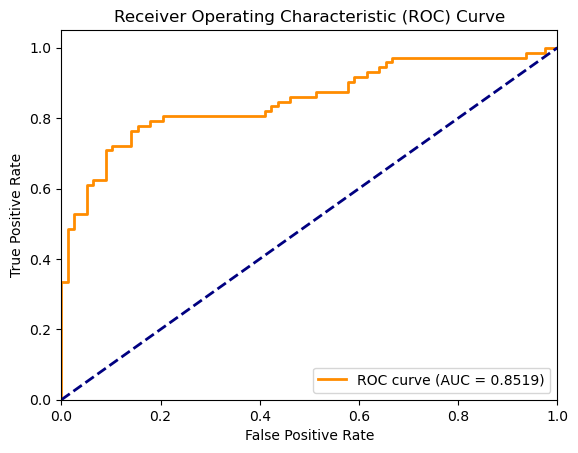

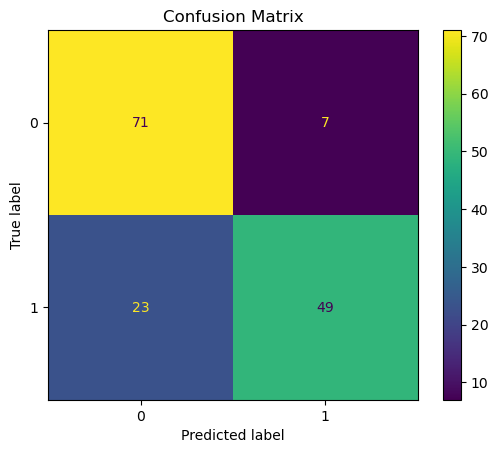

Test Accuracy: 0.8000, Precision: 0.8152, Recall: 0.7954, F1: 0.7956
Original batch shape: torch.Size([2, 57, 1, 224, 224])
Augmented batch shape: torch.Size([2, 57, 1, 224, 224]) | Time: 0.0639
Num instances: 57


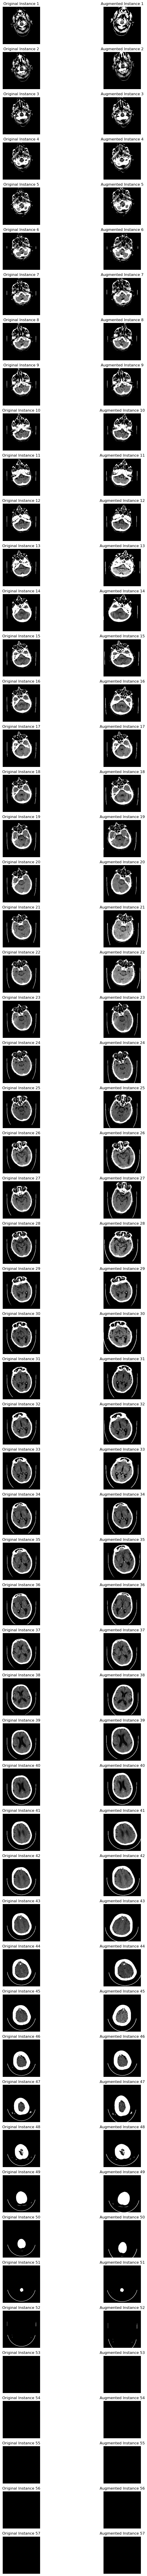

In [35]:
if __name__ == "__main__":
    main(mode='train')

# if __name__ == '__main__':
#     # Set up Optuna study
#     study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
#
#     # Start optimization
#     study.optimize(objective, n_trials=50, timeout=None)
#
#     # Get the best hyperparameters
#     best_params = study.best_trial.params
#     print("Best hyperparameters:", best_params)
#
#     # Retrain the model with the best hyperparameters
#     model_params = {
#         'channels': CHANNELS,
#         'num_classes': NUM_CLASSES,
#         'drop_prob': best_params['drop_prob'],
#         'inducing_points': best_params['inducing_points'],
#         'attention_hidden_dim': best_params['attention_hidden_dim'],
#         'gp_model': 'single_task',
#         'projection_location': 'after_resnet',
#         'projection_hidden_dim': best_params['projection_hidden_dim'],
#         'projection_output_dim': best_params['projection_output_dim']
#     }
#
#     model = CNN_ATT_GP(params=model_params)
#     model.to(DEVICE)
#     likelihood = PGLikelihood().cuda()
#     optimizer = optim.Adam([
#         {'params': model.parameters(), 'lr': best_params['learning_rate']},
#         {'params': likelihood.parameters(), 'lr': best_params['learning_rate']}
#     ])
#
#     # Train the model with the best hyperparameters
#     trained_model = train_model(
#         model=model,
#         likelihood=likelihood,
#         train_loader=train_loader,
#         val_loader=val_loader,
#         criterion_cl=criterion_cl,
#         criterion_bce=criterion_bce,
#         optimizer=optimizer,
#         num_epochs=best_params['num_epochs'],
#         learning_rate=best_params['learning_rate'],
#         device=DEVICE
#     )
#
#     # Evaluate on the test set
#     predictions, labels = evaluate_model(trained_model, likelihood, test_loader, DEVICE)
#     metrics = calculate_metrics(predictions, labels)
#     print_metrics(metrics)